In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import operator, datetime, math, gc, random
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

pd.options.display.max_rows = 800
pd.options.display.max_columns = 800

df = pd.read_csv("./train.csv", engine="c", sep=",", header=None, skiprows=1)

print(tf.__version__)


2.0.0-beta1


In [2]:
# Parses labels from dataset and normalizes features between 0 and 255 
# changed labels to list for consistentcy/ease later

def parse_labels_and_features(dataset):
    labels = dataset[0].tolist()
    features = dataset.loc[:,1:784]
    # Scale the data to [0, 1] by dividing out the max value, 255.
    features = features / 255.0
    return labels, features


In [3]:
# splitting data into training/validation/unlabeled and reshape data

labeled_df = df.head(8400)

training_targets, training_examples = parse_labels_and_features(labeled_df.head(4200))
validation_targets, validation_examples = parse_labels_and_features(labeled_df.tail(4200))
unlabeled_targets, unlabeled_examples = parse_labels_and_features(df.tail(33600))
training_examples = training_examples.values.reshape((4200, 28, 28, 1))
validation_examples = validation_examples.values.reshape((4200, 28, 28, 1))
unlabeled_examples = unlabeled_examples.values.reshape((33600, 28, 28, 1))

# validation (test) pipeline
test_ds = tf.data.Dataset.from_tensor_slices(
    (validation_examples, validation_targets)).batch(32)

# distribution of labels in training dataset, try to maintain similar distribution
Counter(training_targets)


Counter({1: 460,
         0: 425,
         4: 409,
         7: 427,
         3: 386,
         5: 398,
         8: 404,
         9: 401,
         2: 454,
         6: 436})

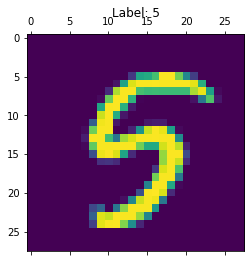

In [4]:
# sanity check to display a random number 

rand_example = np.random.choice(9)
_, ax = plt.subplots()
ax.matshow(training_examples[rand_example].reshape(28, 28))
ax.set_title("Label: %i" % training_targets[rand_example])
ax.grid(False)


In [5]:
# transform functions used by student model

def rotate90(images, k=1):
    images_shape = images.shape
    if len(images_shape) > 4:
        ValueError("'image' must have either 3 or 4 dimensions, "
                   "received `{}`.".format(images_shape))
    if len(images_shape) == 4:
        return tf.map_fn(lambda img: tf.image.rot90(img, k), images)
    return tf.image.rot90(images, k)

def crop(images, central_fraction=0.9):
    return tf.image.resize(tf.map_fn(lambda img: tf.image.central_crop(img, central_fraction), images), [28, 28])


In [6]:
# techer and student models
# TO DO: restructure and possibly add dropout/l1 or l2 normalization

class TeacherModel(Model):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# self.conv1 = self.conv2, but was given an error about 
# creating a new variable on non-initial call when I reused...
# TO DO: preprocess transformations concurrently in ETL process
class StudentModel(Model):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.conv2 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        a = self.conv1(crop(x))
        a = self.flatten(a)
        a = self.d1(a)
        a = self.d2(a)
        b = self.conv2(rotate90(x))
        b = self.flatten(b)
        b = self.d1(b)
        b = self.d2(b)
        return (b+a)/2

teacher_model = TeacherModel()
student_model = StudentModel()


In [7]:
# optimizer & loss/accuracy metrics
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

# Paths for tensorboard logs 
path = '/Users/brianbixby/Desktop/robolab/ai_ml_project/mnist_semi_supervised/logs/gradient_tape/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
teacher_train_summary_writer = tf.summary.create_file_writer(path + '/teacher_train')
teacher_test_summary_writer = tf.summary.create_file_writer(path + '/teacher_test')
student_train_summary_writer = tf.summary.create_file_writer(path + '/student_train')
student_test_summary_writer = tf.summary.create_file_writer(path + '/student_test')


In [8]:
# error was given when I included @tf.function declarations

# @tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)

# @tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)


In [9]:
# takes prediction probability for unlabaleled examples,
# if the probability is above a certain threshold we anontate it and will train on it

def create_unlabeled_predictions(model):
    global unlabeled_examples, unlabeled_targets
    unlabeled_predictions = model(unlabeled_examples)
    unlabeled_training_targets,unlabeled_training_examples,new_unlabeled_examples,new_unlabeled_targets,indexes = [],[],[],[],[]
    i,k = 0,0
    for pred in unlabeled_predictions:
        index, value = max(enumerate(pred), key=operator.itemgetter(1))
        if value > .99999:
            unlabeled_training_targets.append(index)
            unlabeled_training_examples.append(unlabeled_examples[i])
            indexes.append(index)
            k+=1
        else:
            new_unlabeled_examples.append(unlabeled_examples[i])
            new_unlabeled_targets.append(unlabeled_targets[i])
        i+=1
    print("targets newly labeled: ", len(indexes), "unlabeled targets left: ", len(new_unlabeled_targets))
    unlabeled_examples = np.array(new_unlabeled_examples).reshape((len(new_unlabeled_targets), 28, 28, 1))
    unlabeled_targets = new_unlabeled_targets
    return np.array(unlabeled_training_examples).reshape((k, 28, 28, 1)), unlabeled_training_targets


In [10]:
# function that keeps the 60%/40% original labeled data to annontated data ratio while adding newly annontated data

def combine_training_labeled():
    global labeled_training_targets,new_labeled_training_targets,training_targets_copy,labeled_training_examples,new_labeled_training_examples,training_examples_copy,training_targets,training_examples
    multiplier = math.ceil(1.5*len(new_labeled_training_targets))
    training_examples_copy = training_examples_copy.tolist()
    
    training_zip = list(zip(training_examples, training_targets))
    random.shuffle(training_zip)
    training_examples, training_targets = zip(*training_zip)
    
    while multiplier > 4200:
        training_targets_copy.extend(training_targets)
        training_examples_copy.extend(training_examples)
        multiplier -= 4200
    training_targets_copy.extend(training_targets[0:multiplier])
    training_examples_copy.extend(training_examples[0:multiplier])
        
    training_targets_copy.extend(new_labeled_training_targets)
    labeled_training_targets.extend(new_labeled_training_targets)
    training_examples_copy.extend(new_labeled_training_examples.tolist())
    new_labeled_training_targets = []
    training_examples_copy = np.array(training_examples_copy).reshape((len(training_targets_copy), 28, 28, 1))
    labeled_training_examples = labeled_training_examples.tolist()
    labeled_training_examples.extend(new_labeled_training_examples)
    labeled_training_examples = np.array(labeled_training_examples).reshape((len(labeled_training_targets), 28, 28, 1))
    new_labeled_training_examples = np.empty(0)
    gc.collect()
    

In [11]:
EPOCHS,XX = 5,2
labeled_training_targets,new_labeled_training_targets = [],[]
labeled_training_examples,new_labeled_training_examples = np.empty(0),np.empty(0)
training_examples_copy,training_targets_copy = training_examples,list(training_targets)
training_examples = training_examples.tolist()

# quits out of while when less than 1000 unlabeled examples are labeled
while (XX):
    gc.collect()
    if XX != 2:    
        new_labeled_training_examples, new_labeled_training_targets = create_unlabeled_predictions(student_model)
        combine_training_labeled()
    XX = 1 if len(new_labeled_training_targets) > 1000 else 0
    teacher_model = TeacherModel()
    train_teacher_ds = tf.data.Dataset.from_tensor_slices(
        (training_examples_copy, training_targets_copy)).shuffle(len(training_targets_copy)).batch(32)
    for epoch in range(EPOCHS):
        for (x_train, y_train) in train_teacher_ds:
            train_step(teacher_model, optimizer, x_train, y_train)
        with teacher_train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
        for (x_test, y_test) in test_ds:
            test_step(teacher_model, x_test, y_test)
        with teacher_test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1,train_loss.result(),train_accuracy.result()*100,test_loss.result(),test_accuracy.result()*100))
        # Reset metrics every epoch
        train_loss.reset_states(),test_loss.reset_states(),train_accuracy.reset_states(),test_accuracy.reset_states()

    new_labeled_training_examples, new_labeled_training_targets = create_unlabeled_predictions(teacher_model)
    XX = 1 if len(new_labeled_training_targets) > 1000 else XX
    combine_training_labeled()
    student_model = StudentModel()
    train_student_ds = tf.data.Dataset.from_tensor_slices(
        (training_examples_copy, training_targets_copy)).shuffle(len(training_targets_copy)).batch(32)
    for epoch in range(EPOCHS):
        for (x_train, y_train) in train_student_ds:
            train_step(student_model, optimizer, x_train, y_train)
        with student_train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
        for (x_test, y_test) in test_ds:
            test_step(student_model, x_test, y_test)
        with student_test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1,train_loss.result(),train_accuracy.result()*100,test_loss.result(),test_accuracy.result()*100))
        # Reset metrics every epoch
        train_loss.reset_states(),test_loss.reset_states(),train_accuracy.reset_states(),test_accuracy.reset_states()


W0709 21:48:17.049209 140736145658752 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1, Loss: 0.5069196224212646, Accuracy: 84.54762268066406, Test Loss: 0.3005865514278412, Test Accuracy: 90.54762268066406
Epoch 2, Loss: 0.1552024632692337, Accuracy: 95.66666412353516, Test Loss: 0.26130762696266174, Test Accuracy: 91.73809051513672
Epoch 3, Loss: 0.059187281876802444, Accuracy: 98.57142639160156, Test Loss: 0.21867308020591736, Test Accuracy: 93.66666412353516
Epoch 4, Loss: 0.02435634657740593, Accuracy: 99.5714340209961, Test Loss: 0.18511658906936646, Test Accuracy: 95.11904907226562
Epoch 5, Loss: 0.011526469141244888, Accuracy: 99.83333587646484, Test Loss: 0.20559419691562653, Test Accuracy: 94.95237731933594
targets newly labeled:  9044 unlabeled targets left:  24556
Epoch 1, Loss: 0.11733382195234299, Accuracy: 96.5572509765625, Test Loss: 0.19853492081165314, Test Accuracy: 94.4285659790039
Epoch 2, Loss: 0.011989424005150795, Accuracy: 99.70532989501953, Test Loss: 0.2138909250497818, Test Accuracy: 95.21428680419922
Epoch 3, Loss: 0.00724258460104465

In [13]:
# Save the model
# student_model.save('/Users/brianbixby/Desktop/robolab/ai_ml_project/mnist_semi_supervised/student_model.h5')

# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model.h5')